In [100]:
import tensorflow as tf 
import collections
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
words = tf.compat.as_str(open("E:/paper/bg_fusion/text8/text8").read()).split()

In [14]:
def build_dataset(words, vocab_size):
    counts = [["UNK", -1]]
    counts.extend(collections.Counter(words).most_common(vocab_size - 1))
    dictionary = {}
    for word, _ in counts:
        dictionary[word] = len(dictionary)
    word_indices = []
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        word_indices.append(index)
    counts[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return word_indices, counts, dictionary, reverse_dictionary

In [17]:
vocabulary_size = 5000
word_indices, counts, dictionary, reverse_dictionary = build_dataset(words, 5000)

In [20]:
del words

In [92]:
class SkipGramBatchGenerator(object):
    def __init__(self, word_indices, words_per_batch, nsamples_per_word, skip_window = 1, max_nbatch = 5):
        assert nsamples_per_word > 0 and nsamples_per_word <= 2 * skip_window
        assert max_nbatch == -1 or max_nbatch > 0
        self.data_index = 0
        self.word_indices = word_indices
        self.words_per_batch = words_per_batch
        self.nsamples_per_word = nsamples_per_word
        self.skip_window = skip_window
        self.max_nbatch = max_nbatch
        self.__batch_index = 0
    
    def reset(self):
        self.data_index = 0
        self.__batch_index = 0
        
    def generate_batch(self):
        batch_size = self.words_per_batch * self.nsamples_per_word
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
        span = 2 * self.skip_window + 1
        buffer = collections.deque(maxlen=span)
        for _ in range(span):
            buffer.append(self.word_indices[self.data_index])
            self.data_index = (self.data_index + 1) % len(self.word_indices)
        for i in range(self.words_per_batch):
            target = self.skip_window
            targets_to_avoid = [self.skip_window]
            for j in range(self.nsamples_per_word):
                while target in targets_to_avoid:
                    target = np.random.randint(0, span)
                targets_to_avoid.append(target)
                batch[i * self.nsamples_per_word + j] = buffer[self.skip_window]
                labels[i * self.nsamples_per_word + j, 0] = buffer[target]
            buffer.append(self.word_indices[self.data_index])
            self.data_index = (self.data_index + 1) % len(self.word_indices)
        return batch, labels
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.max_nbatch != -1:
            self.__batch_index += 1
            if self.__batch_index > self.max_nbatch:
                raise StopIteration()
        return self.generate_batch()
    
    def print_batch(self, reverse_dictionary):
        for i, (batch, labels) in enumerate(gener):
            print("{:-^64}".format("batch_%s" % i))
            print("|{s1:-^28}| -> |{s2:-^28}|".format(s1="sample", s2="label"))
            for j in range(len(batch)):
                print("[{sample_index:<6}][{sample_word:<20}] -> [{label_index:<6}][{label_word:<20}]".format(
                    sample_index=batch[j], sample_word=reverse_dictionary[batch[j]], 
                    label_index=labels[j, 0], label_word=reverse_dictionary[labels[j, 0]]))

In [95]:
gener = SkipGramBatchGenerator(word_indices, words_per_batch=10, nsamples_per_word=2, skip_window=1, max_nbatch=2)
gener.print_batch(reverse_dictionary=reverse_dictionary)

----------------------------batch_0-----------------------------
|-----------sample-----------| -> |-----------label------------|
[3081  ][originated          ] -> [12    ][as                  ]
[3081  ][originated          ] -> [0     ][UNK                 ]
[12    ][as                  ] -> [3081  ][originated          ]
[12    ][as                  ] -> [6     ][a                   ]
[6     ][a                   ] -> [12    ][as                  ]
[6     ][a                   ] -> [195   ][term                ]
[195   ][term                ] -> [2     ][of                  ]
[195   ][term                ] -> [6     ][a                   ]
[2     ][of                  ] -> [3134  ][abuse               ]
[2     ][of                  ] -> [195   ][term                ]
[3134  ][abuse               ] -> [46    ][first               ]
[3134  ][abuse               ] -> [2     ][of                  ]
[46    ][first               ] -> [3134  ][abuse               ]
[46    ][first           

In [96]:
embedding_size = 128
skip_window = 1
words_per_batch = 64
nsamples_per_word = 2
batch_size = words_per_batch * nsamples_per_word
num_steps = 100001

valid_size = 16
valid_examples = np.random.choice(100, 16, replace=False) + 1
contrast_num_samples = 64

In [87]:
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_samples = tf.constant(valid_examples, dtype=tf.int32)
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / np.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=contrast_num_samples,
                                         num_classes=vocabulary_size))

In [91]:
with graph.as_default():
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_samples)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    init = tf.global_variables_initializer()

In [99]:
batch_generator = SkipGramBatchGenerator(word_indices, words_per_batch=words_per_batch, nsamples_per_word=nsamples_per_word, skip_window=skip_window, max_nbatch=num_steps)
with tf.Session(graph=graph) as sess:
    init.run()
    print("Initialized")
    average_loss = 0
    for step, (batch_inputs, batch_labels) in enumerate(batch_generator):
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        optimizer.run(feed_dict=feed_dict)
        loss_val = loss.eval(feed_dict=feed_dict)
        average_loss += loss_val
        if step % 2000 == 0 and step > 0:
            average_loss /= 2000
            print("Average loss at step", step, ": ", average_loss)
            average_loss = 0
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1: top_k + 1]
                closest_words = []
                for k in nearest:
                    closest_words.append(reverse_dictionary[k])
                print("Nearest to %s: %s" % (valid_word, closest_words))
    final_embeddings = normalized_embeddings.eval()

Initialized
Nearest to over: ['teachings', 'sex', 'duncan', 'managed', 'molecules', 'equations', 'spirit', 'revealed']
Nearest to s: ['experiments', 'ahead', 'delivered', 'elvis', 'lines', 'availability', 'judah', 'religious']
Nearest to as: ['comedian', 'critical', 'wilson', 'rotation', 'teach', 'lyrics', 'mining', 'kuwait']
Nearest to were: ['a', 'storage', 'culture', 'ensure', 'massachusetts', 'skin', 'author', 'order']
Nearest to a: ['python', 'r', 'jonathan', 'photo', 'separation', 'oxygen', 'june', 'good']
Nearest to who: ['chaos', 'saying', 'capitalism', 'burning', 'infrastructure', 'derived', 'denominations', 'isaac']
Nearest to was: ['degrees', 'by', 'proponents', 'arbitrary', 'citizen', 'villages', 'literally', 'commission']
Nearest to history: ['kong', 'reduced', 'care', 'neo', 'feel', 'unless', 'bearing', 'dimensional']
Nearest to many: ['experts', 'brothers', 'foreign', 'super', 'primary', 'establishing', 'discussions', 'terrain']
Nearest to where: ['classes', 'interested'

Average loss at step 42000 :  4.0213983545303345
Average loss at step 44000 :  4.042915088653564
Average loss at step 46000 :  4.038014711141586
Average loss at step 48000 :  3.9664947130680086
Average loss at step 50000 :  4.011159663915634
Nearest to over: ['will', 'can', 'may', 'could', 'to', 'must', 'should', 'monroe']
Nearest to s: ['was', 'are', 'has', 'be', 'were', 'UNK', 'nine', 'does']
Nearest to as: ['kuwait', 'tends', 'award', 'UNK', 'named', 'comedian', 'ready', 'considered']
Nearest to were: ['doubt', 'culture', 'storage', 'skin', 'different', 'order', 'various', 'specialized']
Nearest to a: ['rapid', 'good', 'agave', 'jonathan', 'reign', 'independently', 'separation', 'defence']
Nearest to who: ['denominations', 'recent', 'persia', 'isaac', 'parliamentary', 'burning', 'southeast', 'beyond']
Nearest to was: ['or', 'but', 'nine', 'vs', 'austin', 'UNK', 'eight', 'six']
Nearest to history: ['by', 'between', 'austin', 'kong', 'against', 'from', 'suspended', 'in']
Nearest to ma

Average loss at step 92000 :  4.014731966137886
Average loss at step 94000 :  3.93763794529438
Average loss at step 96000 :  3.9784270870685576
Average loss at step 98000 :  3.8905648795366288
Average loss at step 100000 :  3.9837121706008913
Nearest to over: ['will', 'can', 'may', 'could', 'must', 'should', 'might', 'did']
Nearest to s: ['was', 'has', 'are', 'be', 'does', 'became', 'being', 'UNK']
Nearest to as: ['kuwait', 'named', 'considered', 'used', 'award', 'tends', 'ready', 'promoted']
Nearest to were: ['various', 'different', 'doubt', 'these', 'many', 'tomb', 'skin', 'UNK']
Nearest to a: ['rapid', 'agave', 'some', 'good', 'those', 'many', 'these', 'certain']
Nearest to who: ['denominations', 'recent', 'persia', 'unit', 'isaac', 'bank', 'southeast', 'parliamentary']
Nearest to was: ['but', 'or', 'UNK', 'agave', 'although', 'austin', 'which', 'seven']
Nearest to history: ['between', 'against', 'UNK', 'in', 'for', 'by', 'huge', 'austin']
Nearest to many: ['had', 'has', 'are', 'wer

In [110]:
def plot_with_labels(embeddings, n = 10, offset = 0):
    n += offset
    assert embeddings.shape[0] >= n
    tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
    low_dim_embs = tsne.fit_transform(embeddings[offset: n, :])
    labels = [reverse_dictionary[i] for i in range(offset, n)]
    plt.figure(figsize=(18, 18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha="right", va="bottom")
    plt.show()

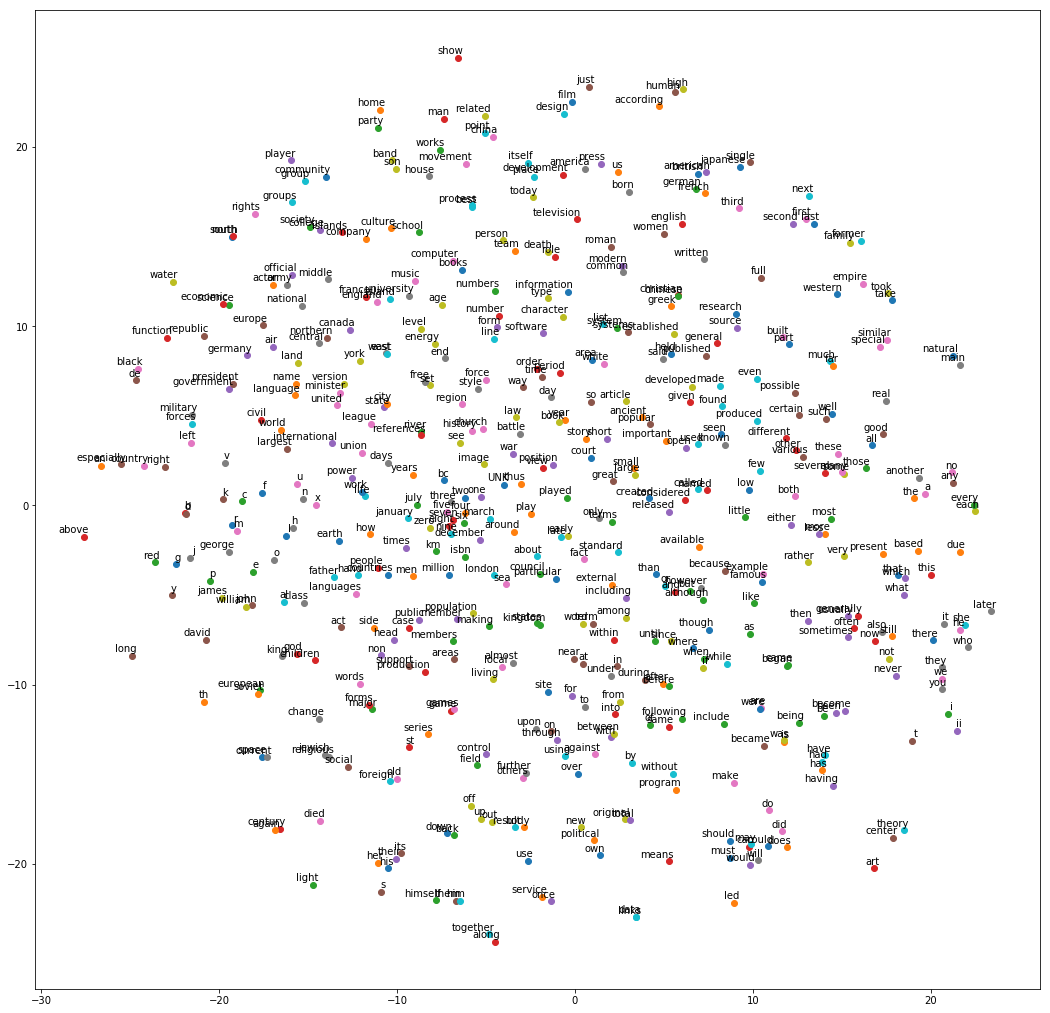

In [113]:
plot_with_labels(final_embeddings, n = 500, offset= 0)

In [114]:
final_embeddings[0]

array([ 0.07862551, -0.01267484,  0.07949995, -0.01742253,  0.11029585,
        0.15374148, -0.04135415, -0.1120416 , -0.03813681, -0.00174787,
        0.02869905,  0.00316249, -0.01720793,  0.03859641,  0.07452513,
        0.08331859, -0.04616749,  0.07012183,  0.03149913,  0.04701687,
       -0.24843639, -0.00319706,  0.06443422,  0.0426126 , -0.01397107,
       -0.06357444,  0.04910491,  0.02681222, -0.0301092 , -0.03245196,
        0.00865655, -0.13465415,  0.02401489, -0.05052365,  0.09664728,
        0.003461  ,  0.01192053, -0.10554281, -0.01760087, -0.04548398,
       -0.0345346 , -0.03698975, -0.01532571, -0.0138408 , -0.01600676,
        0.13655862,  0.0841629 ,  0.0039495 ,  0.07682417,  0.2695712 ,
        0.1287    , -0.0694098 , -0.01974933,  0.01118525, -0.02458759,
       -0.04919326,  0.07925095,  0.05334628, -0.07266215, -0.157807  ,
       -0.17243843, -0.00128919,  0.09654265, -0.00027983,  0.13784716,
       -0.0232258 ,  0.01639048,  0.10009854,  0.01005208,  0.05